## Notebook to analyze video from Evan Ludes with possible pulsating aurora and ground based sound connection

written by Riley Troyer Fall 2021

In [6]:
# Import libraries

import cv2
import numpy as np
import os
from skimage import io, exposure
from skimage.restoration import denoise_nl_means, estimate_sigma
from matplotlib import pyplot as plt

In [7]:
# Where is the data stored
data_dir = '../data/evan-ludes-aurora-videos/'
filename = 'MVI_1458.MOV'

## First step will be to take a look at one of the frames and see what we are working with

In [12]:
def read_grayscale_frame(video, frame):
    """
    Function to read a frame from a opencv VideoCapture object
    INPUT
    vid_file
        type: OpenCV VideoCapture
        description: The object defining the video the frame is in
    frame
        type: int
        description: The frame number to get
    """
    # Read frame
    video.set(1, frame)
    ret, img = video.read()
    
    # Convert to grayscale assuming frames are in rgb
    gs_img = (img[:, :, 0]*0.2989 
              + img[:, :, 1]*0.5870 
              + img[:, :, 2]*0.1140)
    
    return gs_img

In [8]:
# Read in video
video = cv2.VideoCapture(data_dir + filename)

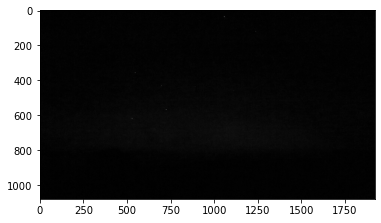

In [17]:
# Plot a frame
frame = 0
gs_img = read_grayscale_frame(video, frame)
plt.imshow(gs_img, cmap='gray')

In [18]:
# Try boosting contrast
low = 0.1
high = 99.9

v_min, v_max = np.percentile(gs_img, (low, high))
contrast_img = exposure.rescale_intensity(gs_img, 
                                   in_range=(v_min, v_max))

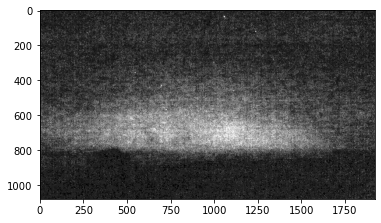

In [19]:
plt.imshow(contrast_img, cmap='gray')